# Team 2 Code

### Names: Nik Sachdeva, Tamilore Kolawole, Annelle McNair, Husna Kider


### Date: 4/19/2022


### PIDs: 730272545, 730322641, 730229248, 730401081


### Jupyter Notebook Number: 7

## Purpose/Objective:
Our objective is to analyze the time to first spike values so that we can create figures comparing the data between male and female VIP or SST mice. In order to find Unit IDs corresponding to Cre+ cells, we will undergo optotagging analysis to identify the types of optotagging stimuli used by the Allen Institute, align spikes to light pulses, and create an array of Unit IDs representing Cre+ units with a light-evoked increase in firing rate. Additionally, we will create a raster plot of the raw data and retrieve time to first spike values for our sessions of interest. We will then match the Cre+ Unit IDs to obtain the desired time to first spike values for each VIP and SST session, and then we will create figures comparing the data between male and female mice. We will use GraphPad Prism to determine whether there are significant differences or interaction effects within the data.

## Protocol:
1. Install/upgrade pip, install allensdk, import necessary libraries
2. Filter sesssions data for male and female subjects with a VIP or SST genotype from the Brain Observatory dataset. 
3. Compare optotagging stimuli conditions and filter experiments to determine which ones incorporated a laser.
4. Align spikes to light pusles by returning a DataArray  
5. Create an array of Unit IDs for Cre+ units with light-evoked increases in firing rate.
6. Create a raster plot of the raw data.
7. Return a table of time to first spike values from a session ID of interest, and download this data into Excel.
8. Match the Cre+ Unit IDs to the time to first spike table to obtain desired values.
9. Create figures comparing time to first spike values between male and female VIP or SST mice.
10. Conduct statistical analyses using GraphPad Prism


## Expected Results:
We expect to output tables of data corresponding to filtered sessions for male and female mice with VIP or SST genotypes from the Brain Observatory dataset. In addition, we expect to output tables showing the optotagging stimuli conditions used for a particular SST or VIP session as well as output an array identifying which experiments used a laser instead of an LED. A plot showing the average firing rate over time for units from the visual cortex  will also be expected to output. We expect to plot the subset of units with a light-evoked increase in firing rate, and return an array of these Cre+ units. Then, we expect to create a raster plot of the raw data. We also expect to return a table of time to first spike values from a session ID of interest. We expect to identify time to first values corresponding to Cre+ Unit IDs, and we expect to find these values for each VIP and SST session. We then expect to create figures comparing these values between male and female VIP or SST mice. Finally, we expect to carry out statistical analyses using GraphPad Prism. 

### Installing AllenSDK into your local environment. 

In [76]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [77]:
pip install allensdk

Defaulting to user installation because normal site-packages is not writeable
  Using cached ruamel.yaml-0.17.21-py3-none-any.whl (109 kB)
Note: you may need to restart the kernel to use updated packages.


### Import Packages:

In [78]:
import os
import shutil
import allensdk
import pprint
from pathlib import Path

import numpy as np
import scipy.stats
import pandas as pd

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

### If working with Visual Coding: Neuropixels Data use the following code block to import the cache object and point it to the data already downloaded and stored on LongLeaf.  Do not change this code.

The following code block was run because our group will be looking at neuropixel data. The code for two-photon imaging was not run.

In [79]:
#this code block should only be run if you are working with the neuropixels data
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = '/overflow/NSCI274/projects/ecephysdata/' 

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## Filtering VIP and SST Sessions For Males and Females


### Research Proposal
    "examining sex differences in the detection of novel images by VIP inhibitory neurons in the mouse visual cortex"


The following code cell delineates the regions of the brain as provided in the dataset.

In [80]:
regions = ['V1','LM','RL','AL','PM','AM']

The following code cell returns the total number of sessions in the Neuropixels dataset.

In [81]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


First we filtered sessions corresponding to the primary visual cortex in VIP-Cre mice for males and females

In [82]:
filtered_sessions_male_target_VISp = sessions[(sessions.sex == 'M') & \
                             (sessions.full_genotype.str.find('Vip') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
print('Total number of sessions: ' + str(len(filtered_sessions_male_target_VISp)))
filtered_sessions_male_target_VISp.head()

Total number of sessions: 3


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
755434585,2019-10-03T00:00:00Z,730760270,brain_observatory_1.1,100.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,650,2220,6,"[grey, VISrl, nan, MGv, MGd, TH, LGd, CA3, DG,..."
762120172,2019-10-03T00:00:00Z,745276236,brain_observatory_1.1,100.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,717,1860,5,"[grey, VISal, nan, VISl, VISp, VIS, VISam]"
791319847,2019-10-03T00:00:00Z,769360779,brain_observatory_1.1,116.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,555,2229,6,"[APN, DG, CA1, VISam, nan, LP, TH, VISpm, POL,..."


In [83]:
filtered_sessions_female_target_VISp = sessions[(sessions.sex == 'F') & \
                             (sessions.full_genotype.str.find('Vip') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
print('Total number of sessions: ' + str(len(filtered_sessions_female_target_VISp)))
filtered_sessions_female_target_VISp.head()

Total number of sessions: 2


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
751348571,2019-10-03T00:00:00Z,732548380,brain_observatory_1.1,93.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,859,2217,6,"[grey, LGv, CA3, DG, CA1, VISl, nan, APN, POL,..."
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."


Then we filtered sessions corresponding to the primary visual cortex in SST-Cre mice for males and females

In [84]:
filtered_sessions_male_target_VISp = sessions[(sessions.sex == 'M') & \
                             (sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
print('Total number of sessions: ' + str(len(filtered_sessions_male_target_VISp)))
filtered_sessions_male_target_VISp.head()

Total number of sessions: 5


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
762602078,2019-10-03T00:00:00Z,744915204,brain_observatory_1.1,110.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,531,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, VISrl, LGv..."


In [85]:
filtered_sessions_female_target_VISp = sessions[(sessions.sex == 'F') & \
                             (sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
print('Total number of sessions: ' + str(len(filtered_sessions_female_target_VISp)))
filtered_sessions_female_target_VISp.head()

Total number of sessions: 1


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


## Plotting Optotagging Data for Inhibitory Neuron Sessions


The following code contains info about the genotypes of mice used in each experiment from the Allen Insitute. We are particlarly interested in the VIP and SST sessions.

In [86]:
sessions = cache.get_session_table()

sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64

The following code filters the sessions table above in order to identify experiments performed on VIP-Cre and SST-Cre mice from the brain observatory dataset. The functional connectivity dataset does not show time to peak values, so only brain observatory sessions were filtered. 

In [87]:
inhibitory_sessions = sessions[(sessions.full_genotype.str.match('Vip')| \
                        (sessions.full_genotype.str.match('Sst')))& \
                        (sessions.session_type =='brain_observatory_1.1')]

inhibitory_sessions

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
751348571,2019-10-03T00:00:00Z,732548380,brain_observatory_1.1,93.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,859,2217,6,"[grey, LGv, CA3, DG, CA1, VISl, nan, APN, POL,..."
755434585,2019-10-03T00:00:00Z,730760270,brain_observatory_1.1,100.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,650,2220,6,"[grey, VISrl, nan, MGv, MGd, TH, LGd, CA3, DG,..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"
762120172,2019-10-03T00:00:00Z,745276236,brain_observatory_1.1,100.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,717,1860,5,"[grey, VISal, nan, VISl, VISp, VIS, VISam]"
762602078,2019-10-03T00:00:00Z,744915204,brain_observatory_1.1,110.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,531,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, VISrl, LGv..."


In order to extract information about the optotagging stimuli that were delivered, the following code loads one of the sessions above and returns a table showing info about each optotagging trial. 

In [88]:
session = cache.get_session_data(inhibitory_sessions.index.values[2])
session.optogenetic_stimulation_epochs

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9224.38252,a single square pulse,2.5,9224.38752,pulse,0.005
1,9226.11255,2.5 ms pulses at 10 Hz,1.0,9227.11255,fast_pulses,1.000
2,9228.22260,half-period of a cosine wave,4.0,9229.22260,raised_cosine,1.000
3,9229.99272,a single square pulse,1.0,9230.00272,pulse,0.010
4,9232.08281,a single square pulse,4.0,9232.08781,pulse,0.005
...,...,...,...,...,...,...
175,9560.72716,a single square pulse,2.5,9560.73716,pulse,0.010
176,9562.45739,a single square pulse,2.5,9562.46739,pulse,0.010
177,9564.59737,half-period of a cosine wave,2.5,9565.59737,raised_cosine,1.000


The following code returns a table showing the unique optotagging stimuli conditions across all trials.

In [89]:
columns = ['stimulus_name', 'duration','level']

session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])


,condition,level,stimulus_name,duration
id,,,,
1,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
48,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
19,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
17,a single square pulse,1.0,pulse,0.005
0,a single square pulse,2.5,pulse,0.005
4,a single square pulse,4.0,pulse,0.005
3,a single square pulse,1.0,pulse,0.010
5,a single square pulse,2.5,pulse,0.010
16,a single square pulse,4.0,pulse,0.010


Since the Allen Institute switched from delivering light through an LED to a laser a little more than halfway through their data collections, the following code filters experiments to determine which ones used a laser. A laser evokes a stronger optotagging response than an LED.

In [90]:
sessions.index.values >= 789848216

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

For a certain stimulus condition (10 ms pulses) and set of units (visual cortex only), the following code creates a DataArray with binned spikes aligned to the start of each stimulus. 

In [91]:
import xarray as xr
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]

units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

time_resolution = 0.0005 # 0.5 ms bins

bin_edges = np.arange(-0.01, 0.025, time_resolution)

def optotagging_spike_counts(bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

da = optotagging_spike_counts(bin_edges, trials, units)

The following code uses the DataArray from above to plot the average firing rate for each unit over time. 

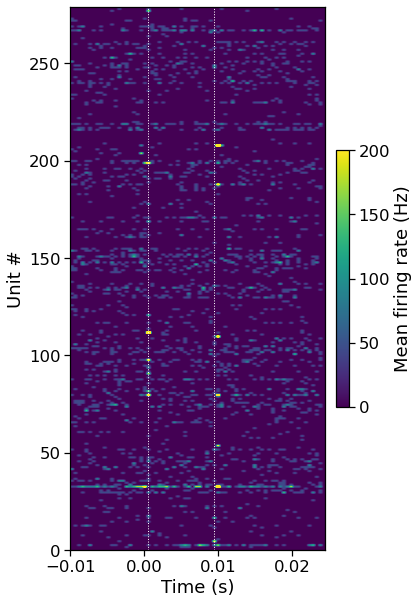

In [92]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)

Based on the plot above, only one unit is responding to the 10 ms light pulse. 

## Identifying Cre+ Units

The following code searches for units that increase their firing rate during the 10 ms pulse using the DataArray from above, and then creates a plot of these units. 

In [93]:
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

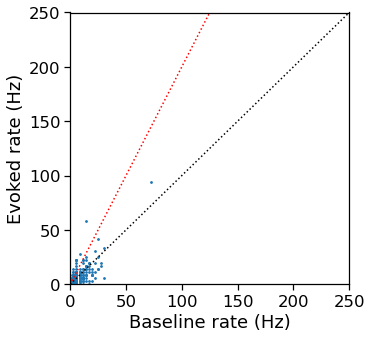

In [94]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

The following code creates an array of Unit IDs for Cre+ units for a certain threshold (a 2 times increase in firing rate).

In [95]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors

cre_pos_units

array([951888034, 951888009, 951887997, 951887978, 951888243, 951888164,
       951888342, 951888742, 951889651, 951897534, 951897570, 951897847,
       951897838, 951897882, 951897918, 951898268, 951898281, 951898055,
       951893064, 951893453, 951893740, 951893982, 951867407, 951867956,
       951882307, 951883145, 951883778, 951876454, 951874626, 951874602,
       951874589, 951874737, 951874683, 951876824, 951875265, 951875248,
       951876638, 951875895, 951876702])

## Creating a Raster Plot of the Raw Data

The following code creates a raster plot showing responses from units from one female VIP inhibitory session for one natural scene.

In [96]:
session_id = inhibitory_sessions.index.values[2]

session = cache.get_session_data(session_id)

In [97]:
units = session.units

print('Total number of units: ' + str(len(units)))

units.head()

Total number of units: 859


,waveform_recovery_slope,waveform_spread,d_prime,waveform_velocity_above,silhouette_score,cluster_id,waveform_velocity_below,max_drift,local_index_unit,peak_channel_id,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951884658,-0.097751,60.0,6.424807,0.274707,0.156611,5,-1.030151,20.66,5,850162560,...,215.0,APN,8359.0,3569.0,7103.0,probeA,See electrode locations,29999.968567,1249.99869,True
951884671,-0.186479,110.0,5.585843,0.572306,0.150050,6,0.686767,30.15,6,850162562,...,215.0,APN,8356.0,3560.0,7106.0,probeA,See electrode locations,29999.968567,1249.99869,True
951884744,-0.155592,70.0,5.581539,0.274707,0.135499,11,0.000000,32.32,11,850162570,...,215.0,APN,8344.0,3524.0,7119.0,probeA,See electrode locations,29999.968567,1249.99869,True
951884784,-0.204997,100.0,2.563066,0.627901,0.066096,14,0.137353,54.65,14,850162576,...,215.0,APN,8335.0,3496.0,7129.0,probeA,See electrode locations,29999.968567,1249.99869,True
951884731,-0.098164,130.0,4.048063,0.793053,0.146873,10,0.313951,33.10,10,850162576,...,215.0,APN,8335.0,3496.0,7129.0,probeA,See electrode locations,29999.968567,1249.99869,True


In [98]:
session_units = units[(units.ecephys_structure_acronym == 'VISp') &
                (units.isi_violations < 0.1)]

print('Total number of low-contamination units: ' + str(len(session_units)))

Total number of low-contamination units: 32


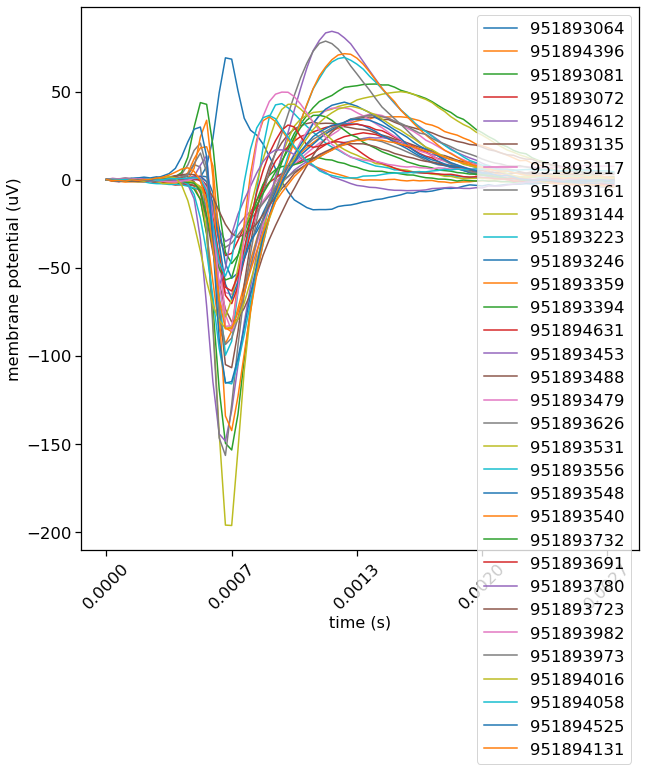

In [99]:
units_of_interest = session_units.index.values

waveforms = {uid: session.mean_waveforms[uid] for uid in units_of_interest}
peak_channels = {uid: session.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest}

# plot the mean waveform on each unit's peak channel/
plot_mean_waveforms(waveforms, units_of_interest, peak_channels)
plt.show()

In [100]:
stim_table = session.get_stimulus_table(['natural_scenes'])

stim_table.head()

/nas/longleaf/home/nikhil1/.local/lib/python3.8/site-packages/allensdk/brain_observatory/ecephys/stimulus_table/naming_utilities.py:154: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_rows = table[stim_colname].str.contains(movie_re, na=False)


,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51355,19.0,5909.137826,9.0,natural_scenes,5909.388033,0.250207,4908
51356,81.0,5909.388033,9.0,natural_scenes,5909.638240,0.250207,4909
51357,25.0,5909.638240,9.0,natural_scenes,5909.888448,0.250207,4910
51358,10.0,5909.888448,9.0,natural_scenes,5910.138655,0.250207,4911
51359,86.0,5910.138655,9.0,natural_scenes,5910.388863,0.250208,4912


In [101]:
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'natural_scenes']

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

In [102]:
times = session.presentationwise_spike_times(
    stimulus_presentation_ids=presentation_ids,
    unit_ids=units_of_interest
)

times

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5909.152591,51355,951893479,0.014765
5909.158257,51355,951893246,0.020432
5909.164357,51355,951894396,0.026532
5909.170791,51355,951893117,0.032965
5909.173891,51355,951893359,0.036065
...,...,...,...
8568.816308,68228,951893064,0.206860
8568.830608,68228,951893531,0.221160
8568.832441,68228,951893488,0.222993


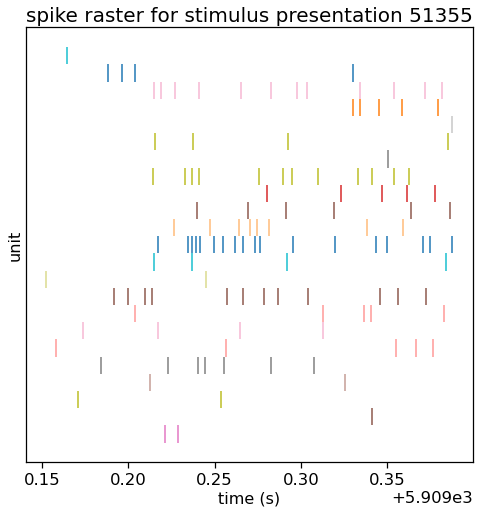

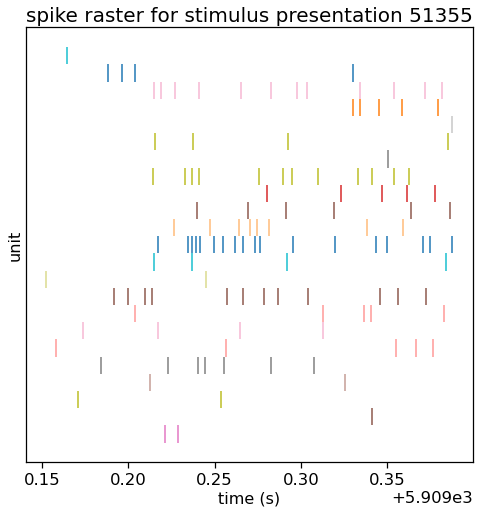

In [103]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

raster_plot(plot_times,
            title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')

## Retrieving Metric Data

The following code returns a table of all the metrics for Unit IDs corresponding to a session ID of interest.

In [104]:
session_id = 751348571
session = cache.get_session_data(session_id)
cre_units = session.units
cre_units

,waveform_recovery_slope,waveform_spread,d_prime,waveform_velocity_above,silhouette_score,cluster_id,waveform_velocity_below,max_drift,local_index_unit,peak_channel_id,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951884658,-0.097751,60.0,6.424807,0.274707,0.156611,5,-1.030151,20.66,5,850162560,...,215.0,APN,8359.0,3569.0,7103.0,probeA,See electrode locations,29999.968567,1249.998690,True
951884671,-0.186479,110.0,5.585843,0.572306,0.150050,6,0.686767,30.15,6,850162562,...,215.0,APN,8356.0,3560.0,7106.0,probeA,See electrode locations,29999.968567,1249.998690,True
951884744,-0.155592,70.0,5.581539,0.274707,0.135499,11,0.000000,32.32,11,850162570,...,215.0,APN,8344.0,3524.0,7119.0,probeA,See electrode locations,29999.968567,1249.998690,True
951884784,-0.204997,100.0,2.563066,0.627901,0.066096,14,0.137353,54.65,14,850162576,...,215.0,APN,8335.0,3496.0,7129.0,probeA,See electrode locations,29999.968567,1249.998690,True
951884731,-0.098164,130.0,4.048063,0.793053,0.146873,10,0.313951,33.10,10,850162576,...,215.0,APN,8335.0,3496.0,7129.0,probeA,See electrode locations,29999.968567,1249.998690,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951875828,-0.004512,60.0,3.944161,1.236181,0.070705,433,-0.343384,55.09,423,850157712,...,417.0,VISrl,7547.0,1183.0,9008.0,probeF,See electrode locations,30000.039940,1250.001664,True
951875913,-0.076702,50.0,4.602298,0.686767,0.048005,437,0.686767,18.54,427,850157716,...,417.0,VISrl,7543.0,1163.0,9013.0,probeF,See electrode locations,30000.039940,1250.001664,True
951875895,-0.119318,40.0,3.383277,0.686767,0.084355,436,0.686767,50.39,426,850157716,...,417.0,VISrl,7543.0,1163.0,9013.0,probeF,See electrode locations,30000.039940,1250.001664,True


In [105]:
session.units.time_to_peak_ns

unit_id
951884658    0.0935
951884671    0.0745
951884744    0.0915
951884784    0.1265
951884731    0.0565
              ...  
951875828    0.1065
951875913    0.0695
951875895    0.1905
951876702    0.0915
951875978    0.0905
Name: time_to_peak_ns, Length: 859, dtype: float64

The following code returns a table showing the mean time to peak response to natural scenes values corresponding to the Cre+ Unit IDs from the array above. A mask was utilized to filter the time to peak values table for unit IDs that matched the Cre+ Unit ID array. 

In [106]:
table = session.units.time_to_peak_ns
table = table.to_frame()
mask = []
for unit_id, time in table.iterrows():
        if unit_id in cre_pos_units:
            mask.append(True)
        else: 
            mask.append(False)
result = table[mask]
result

,time_to_peak_ns
unit_id,
951888034,0.1035
951888009,0.1485
951887997,0.0815
951887978,0.1115
951888243,0.0635
951888164,0.0815
951888342,0.1875
951888742,0.1405
951889651,0.1745


In order to obtain filtered time to first spike values for each session ID, we changed the index value and specified a session ID in the code above.

We  compiled tables of time to peak values for each SST and VIP session ID, and entered the data in GraphPad Prism. GraphPad Prism was subsequently used to visualize the data with scatter plots and conduct statistical analyses. 

## Resources:
Optotagging analysis code was from Optotagging Analysis from the Allen Institute for Brain Science: https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_optotagging.html

Markdown text and code for this Jupyter notebook were from the Neuropixels Visual Coding Tutorial from Allen Institute for Brain Science: https://github.com/AllenInstitute/brain_observatory_examples/blob/master/Open%20for%20NeuroScience%202020/Open%20for%20(Neuro)Science%202021%20-%20Neuropixels%20Visual%20Coding%20ANSWER%20KEY.ipynb


The function for calculating the change modulation index was from code from the Siegle et al. (2021) paper: https://github.com/AllenInstitute/neuropixels_platform_paper/blob/master/functions/modulation_index.py

### Sample Allen Jupyter Notebooks to get started:
https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html
https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html